# Posterior predictive checks for the speed of light data

In [15]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, pymc3 as pm, arviz as az, os
import plot_tools

## Normal model

In [2]:
# From Aki Vehtari's demos
# data
data_path = os.path.abspath(
    os.path.join(
        os.path.curdir,
        'utilities_and_data',
        'light.txt'
    )
)
#y = pd.DataFrame(data = np.loadtxt(data_path), columns = ['time'])
y = np.loadtxt(data_path)
#y = np.concatenate((y[:5], y[6:]))
n = len(y)
s2 = np.var(y, ddof=1)  # Here ddof=1 is used to get the sample estimate.
s = np.sqrt(s2)
my = np.mean(y)

In [3]:
y = np.concatenate((y[:5], y[6:]))
y

array([28., 26., 33., 24., 34., 27., 16., 40., -2., 29., 22., 24., 21.,
       25., 30., 23., 29., 31., 19., 24., 20., 36., 32., 36., 28., 25.,
       21., 28., 29., 37., 25., 28., 26., 30., 32., 36., 26., 30., 22.,
       36., 23., 27., 27., 28., 27., 31., 27., 26., 33., 26., 32., 32.,
       24., 39., 28., 24., 25., 32., 25., 29., 27., 28., 29., 16., 23.])

In [4]:
replicates = np.random.standard_t(n-1, size=(9,n)) * np.sqrt(1+1/n)*s + my

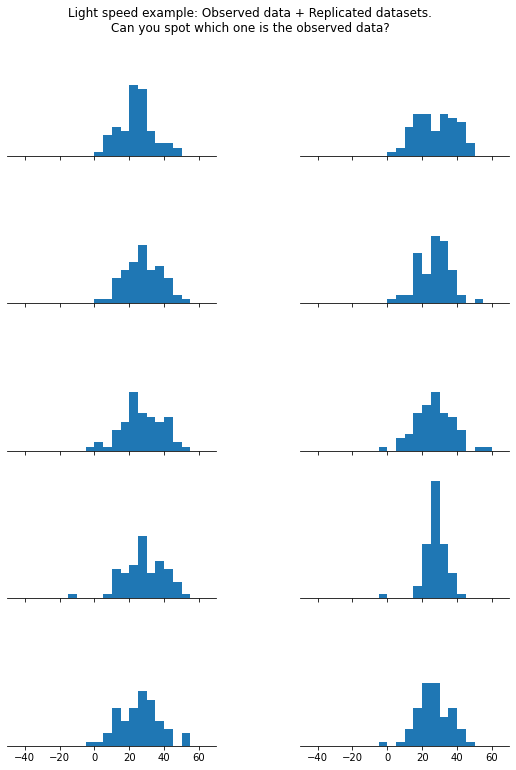

In [5]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
order = np.random.permutation(10)
for i, ax in enumerate(axes.flat):
    ax.hist(
        replicates[order[i]] if order[i] < 9 else y,
        np.arange(-45, 65, 5)
    )
    plot_tools.modify_axes.only_x(ax)
axes[0, 0].set_xlim([-50, 70])
fig.suptitle(
    "Light speed example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);

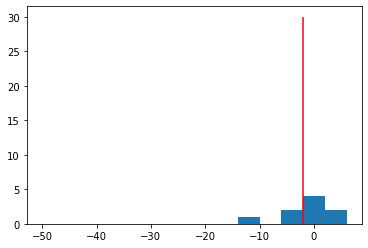

In [6]:
minimums = np.min(replicates, axis = 1)
plt.hist(minimums, bins=np.arange(-50, 10, 4))
plt.vlines(x=np.min(y), ymin=0, ymax=30, color = 'red')
plt.show()

In [8]:
# Normal model in PyMC3
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', 5)
    m = pm.Normal('m', 0, 50)
    nu = pm.HalfCauchy('nu', 5)
    y_obs = pm.Normal('y_obs', mu = m, sigma = sigma, observed = y)
    
    trace_norm = pm.sample()
    
    replicates = pm.sample_posterior_predictive(trace_norm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, m, sigma]
100%|██████████| 2000/2000 [00:01<00:00, 1526.67it/s]


## Student T model

In [9]:
# Student T Model
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', 5)
    m = pm.Normal('m', 0, 50)
    nu = pm.HalfCauchy('nu', 5)
    y_obs = pm.StudentT('y_obs', nu = nu, mu = m, sigma = sigma, observed = y)
    
    trace_T = pm.sample()
    
    replicates = pm.sample_posterior_predictive(trace_T)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, m, sigma]
100%|██████████| 2000/2000 [00:01<00:00, 1793.61it/s]


In [10]:
yrep = replicates['y_obs'][:10]
replicates['y_obs'].shape

(2000, 65)

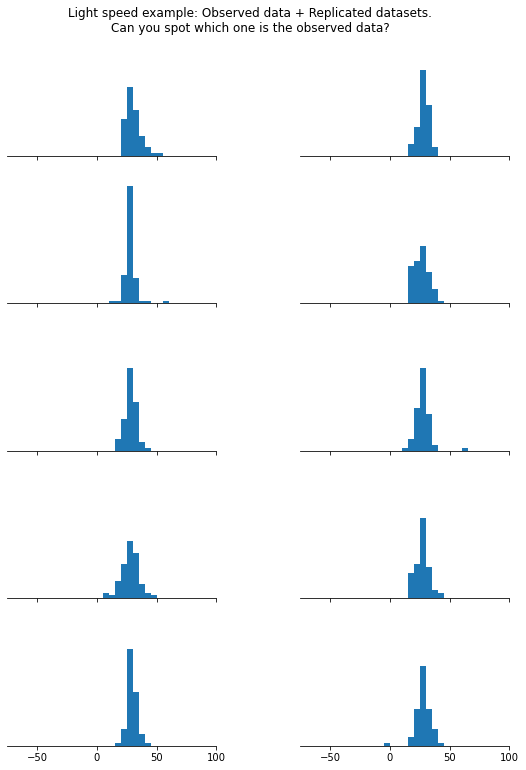

In [11]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
order = np.random.permutation(10)
for i, ax in enumerate(axes.flat):
    ax.hist(
        yrep[order[i]] if order[i] < 9 else y,
        np.arange(-75, 100, 5)
    )
    plot_tools.modify_axes.only_x(ax)
axes[0, 0].set_xlim([-75, 100])
fig.suptitle(
    "Light speed example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);

## Cauchy model

In [12]:
# Cauchy Model
with pm.Model() as model:
    beta = pm.HalfCauchy('beta', 5)
    alpha = pm.Normal('alpha', 0, 50)
    y_obs = pm.Cauchy('y_obs', alpha = alpha, beta = beta, observed = y)
    
    trace_C = pm.sample()
    
    replicates = pm.sample_posterior_predictive(trace_C)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4217.99draws/s]
The acceptance probability does not match the target. It is 0.8905025384085573, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:00<00:00, 3531.69it/s]


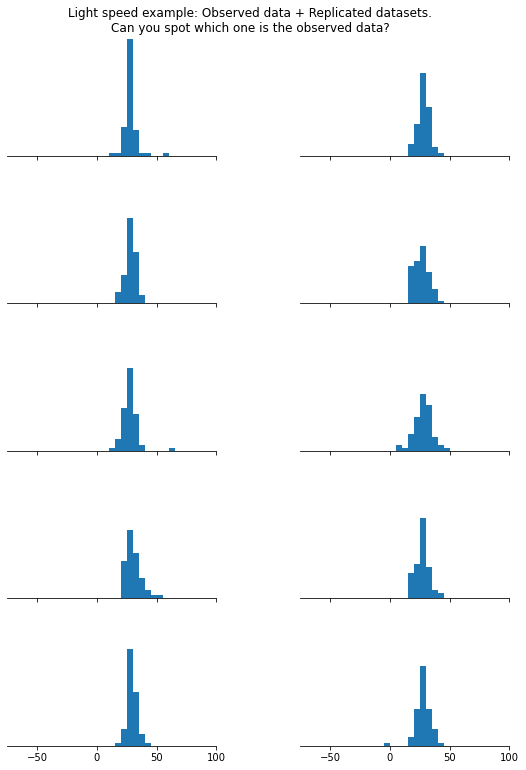

In [13]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
order = np.random.permutation(10)
for i, ax in enumerate(axes.flat):
    ax.hist(
        yrep[order[i]] if order[i] < 9 else y,
        np.arange(-75, 100, 5)
    )
    plot_tools.modify_axes.only_x(ax)
axes[0, 0].set_xlim([-75, 100])
fig.suptitle(
    "Light speed example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);

In [17]:
pm.compare({'Normal':trace_norm, 'StudentT':trace_T, 'Cauchy':trace_C}, ic='waic', scale = 'deviance')

/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
StudentT,0,414.873,3.23898,0,0.811671,15.663,0,True,deviance
Cauchy,1,424.533,2.08203,9.66004,0.106082,25.8156,7.06553,False,deviance
Normal,2,428.972,4.69225,14.099,0.0822463,17.6646,12.6712,True,deviance


In [18]:
pm.compare({'Normal':trace_norm, 'StudentT':trace_T, 'Cauchy':trace_C}, ic='loo', scale = 'deviance')

/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
StudentT,0,415.429,3.51722,0,0.778793,15.6013,0,True,deviance
Cauchy,1,424.531,2.08119,9.10187,0.12781,26.5906,7.537,False,deviance
Normal,2,428.772,4.59229,13.3426,0.0933977,18.4272,11.9717,True,deviance
